In [60]:
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

[link to the bike rental dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#)

## Lets begin with day-wise analysis

In [18]:
data = pd.read_csv("./christophM_datasets/bike_sharing/day.csv")
display(data.head())

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## data description

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not.
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling(**feels like**) temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered 

### Inferences and further operations
1. `cnt` is the dependent variable, to be predicted.
2. `instant` and `dteday` can be filtered out.
3. all categorical variables will now be treatment-coded.

In [19]:
# drop instant and dteday
data.drop(['instant', 'dteday'], axis=1, inplace=True)
display(data.head(10))

# checking datatypes for all features
print(data.dtypes)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
5,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
6,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
7,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
8,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822
9,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321


season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


In [20]:
print("categories for season:", data['season'].unique())
print("categories for year:", data['yr'].unique())
print("categories for month:", data['mnth'].unique())
print("categories for holiday:", data['holiday'].unique())
print("categories for weekday:", data['weekday'].unique())
print("categories for workingday:", data['workingday'].unique())
print("categories for weathersit:", data['weathersit'].unique())

categories for season: [1 2 3 4]
categories for year: [0 1]
categories for month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
categories for holiday: [0 1]
categories for weekday: [6 0 1 2 3 4 5]
categories for workingday: [0 1]
categories for weathersit: [2 1 3]


In [21]:
categorical_features = [
    'season',
    'yr',
    'mnth',
    'holiday',
    'weekday',
    'workingday',
    'weathersit'
]
treatment_mat = pd.get_dummies(data['season'], drop_first=True)
current_categories = treatment_mat.columns
treatment_mat.columns = ['season_{}'.format(i) for i in current_categories]

for feature in categorical_features:
    treatment_mat = pd.get_dummies(data[feature], drop_first=True)
    current_categories = treatment_mat.columns
    treatment_mat.columns = ['{}_{}'.format(feature, i) for i in current_categories]
    data.drop([feature], axis=1, inplace=True)
    data = pd.concat([data, treatment_mat], axis=1)
    
display(data.head())

,temp,atemp,hum,windspeed,casual,registered,cnt,season_2,season_3,season_4,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,0.344167,0.363625,0.805833,0.160446,331,654,985,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0.363478,0.353739,0.696087,0.248539,131,670,801,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [22]:
print(data.columns)

Index(['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt',
       'season_2', 'season_3', 'season_4', 'yr_1', 'mnth_2', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10',
       'mnth_11', 'mnth_12', 'holiday_1', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday_1',
       'weathersit_2', 'weathersit_3'],
      dtype='object')


## New feature interpretation

1. season_2, season_3, season_4 denote spring, summer and fall respectively.
    1. when all the 3 are 0, it means winter.
2. yr_1 means 2012, if 0 then thats 2011.
3. mnth_2 to mnth_12 means Feb-December, when all of these are 0s, it means January.
4. weekday_1 to weekday_6 means Monday to Saturday, all 0s means Sunday.
5. `weathersit_2` means
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
6. `weathersit_3` : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - when both are 0, it means Clear, Few clouds, Partly cloudy, Partly cloudy

### Divide the dataset into training and test sets

In [23]:
X, y = data.drop(['cnt'], axis=1), data['cnt']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

print("the shape of x-train is {}, y-train is {}, x-test is {}, y-test is {}.".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

the shape of x-train is (511, 31), y-train is (511,), x-test is (220, 31), y-test is (220,).


In [25]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(x_train, y_train)

print("R\u00b2 for this basic model is {}".format(lr.score(x_test, y_test)))
# intercept, weights = 

R² for this basic model is 1.0


In [27]:
from json import dumps
print(dumps(dict(zip(X.columns, lr.coef_)), indent=2))

{
  "temp": -1.0296392555707163e-11,
  "atemp": 9.851514233168503e-12,
  "hum": -5.947718858371499e-13,
  "windspeed": -1.8363861291660166e-12,
  "casual": 1.0000000000000002,
  "registered": 0.9999999999999987,
  "season_2": -4.495758377458132e-14,
  "season_3": -5.858307893954871e-13,
  "season_4": 4.2189413264549615e-13,
  "yr_1": 4.983099747910146e-13,
  "mnth_2": 4.231083080980925e-13,
  "mnth_3": 2.4655398680678435e-13,
  "mnth_4": 5.880793221929541e-13,
  "mnth_5": 1.298061661930981e-14,
  "mnth_6": 1.0104889715291395e-13,
  "mnth_7": -5.949581231171266e-14,
  "mnth_8": 1.279163636596428e-13,
  "mnth_9": 3.0981123744871003e-13,
  "mnth_10": -3.0765094689197466e-14,
  "mnth_11": 1.342289725879954e-13,
  "mnth_12": 1.1959580435983648e-13,
  "holiday_1": -1.9350816705030473e-14,
  "weekday_1": 1.503630003411776e-14,
  "weekday_2": -1.2046680279608376e-13,
  "weekday_3": -6.607538815654233e-14,
  "weekday_4": -1.529677805510267e-13,
  "weekday_5": 7.677118912177752e-14,
  "weekday_6

* Since scikit-learn doesn't provide with the results of the estimates , i.e. mean value and std. error in the estimation of weights, we resort to `statsmodels`.

* OLS, i.e. ordinary least squares regression is used, from the [`statsmodels`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html?highlight=ols#statsmodels.regression.linear_model.OLS) module. 

In [33]:
import statsmodels.api as smapi

'''
add the [1 1 1 ...] column for intercept, since statsmodel api requires it, but the OLS class doesn't add by 
itself
'''
x_train_intercept_added = smapi.add_constant(x_train) 
model = smapi.OLS(y_train, x_train_intercept_addedntercept_added)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.120e+29
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:16:05   Log-Likelihood:                 12182.
No. Observations:                 511   AIC:                        -2.430e+04
Df Residuals:                     480   BIC:                        -2.417e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.002e-12   4.35e-12      1.150   

,feature,weight
0,const,-3.546375e-12
1,const,1.355082e-11
2,temp,-3.367769e-11
3,temp,5.186759e-11
4,atemp,-6.227224e-11
...,...,...
59,workingday_1,2.915501e-12
60,weathersit_2,-6.512313e-13
61,weathersit_2,4.743957e-12
62,weathersit_3,-7.599659e-12


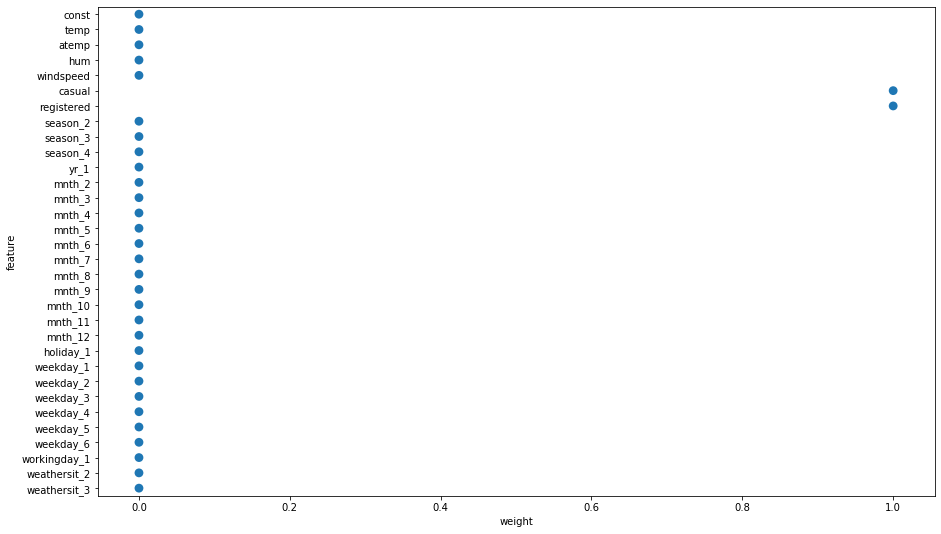

In [61]:
def create_dataframe_from_confidence_intervals(confid_interv):
    columns = ['feature', 'weight']
    num_features = confid_interv.shape[0]
    value_list = []
    for i in range(num_features):
        curr_row = confid_interv.iloc[i, :]
        value_list.append([curr_row['index'], curr_row[0]])
        value_list.append([curr_row['index'], curr_row[1]])
    df = pd.DataFrame(columns=columns, data=value_list)
    return df

# confidence intervals
confid_interv = results.conf_int().reset_index()
# display(confid_interv)
modified_confid_interv = create_dataframe_from_confidence_intervals(confid_interv)
display(modified_confid_interv)

plt.figure(figsize=(15, 9))
sns.pointplot(x="weight", y="feature", data=modified_confid_interv, join=False)

Since casual and registered have very high weight estimates when compared to other features, we will visualize them in a separate plot

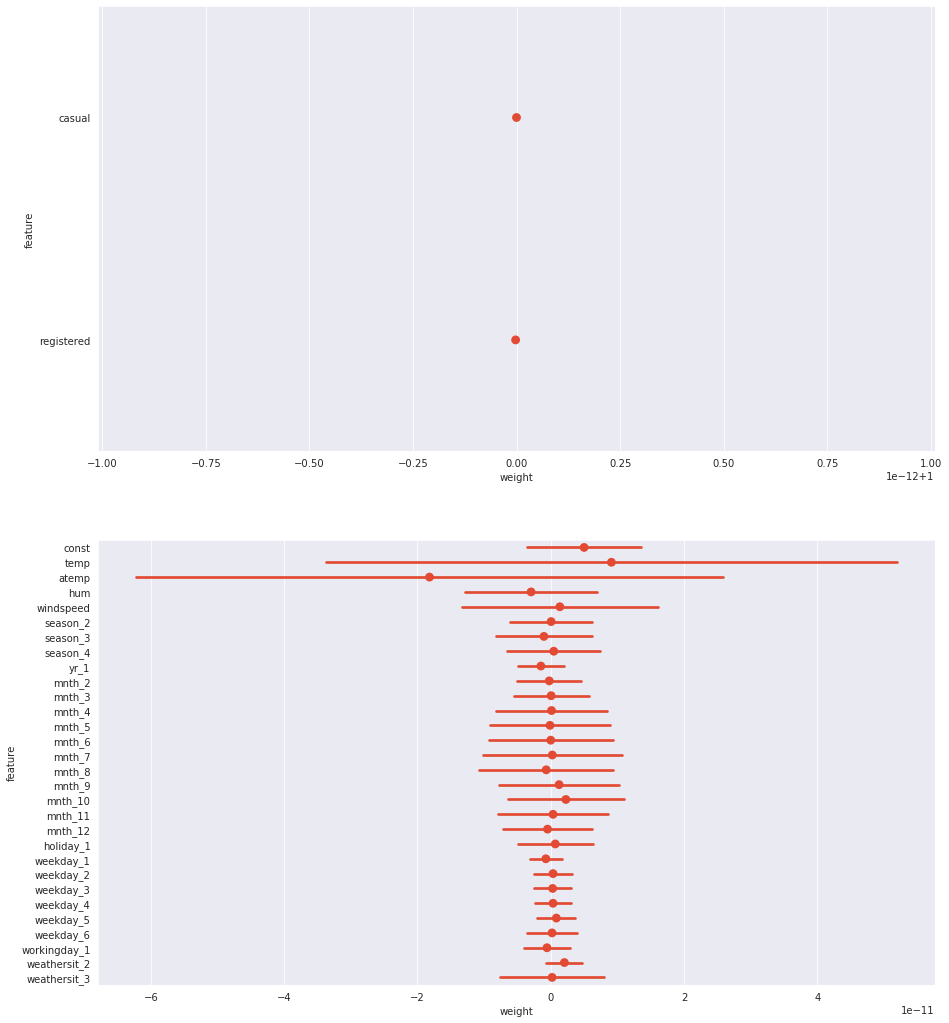

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(15, 18))

plt.style.use('ggplot')

sns.pointplot(
    x="weight", 
    y="feature", 
    data=modified_confid_interv[(modified_confid_interv['feature'] == 'casual') | (modified_confid_interv['feature'] == 'registered')], 
    join=False, 
    ax=ax[0]
)

sns.pointplot(
    x="weight", 
    y="feature", 
    data=modified_confid_interv[(modified_confid_interv['feature'] != 'casual') & (modified_confid_interv['feature'] != 'registered')], 
    join=False, 
    ax=ax[1]
)

# sns.pointplot(x="weight", y="feature", data=modified_confid_interv, join=False, ax=ax[1])


1. `casual` and `registered` have exact estimates of 1, no variance.
2. out of the other features, `temp` and `atemp` have the largest confidence intervals.
    - and these 2 features are the ones that cause the maximum negative effect on the number of bikes rented, which is quite logical.
    
 

## feaure normalized weight plots

## Effect plot

Construct the effect matrix from the weight vector and feature matrix.

In [120]:
weights = results.params
features = x_train_intercept_added.columns

effect_data = x_train_intercept_added.copy()

for feature in features:
    print(effect_data[feature], "\n\n\n")
    effect_data[feature] *= weights[feature]
    print(effect_data[feature])

586    1.0
208    1.0
476    1.0
508    1.0
395    1.0
      ... 
621    1.0
128    1.0
57     1.0
341    1.0
116    1.0
Name: const, Length: 511, dtype: float64 



586    5.002221e-12
208    5.002221e-12
476    5.002221e-12
508    5.002221e-12
395    5.002221e-12
           ...     
621    5.002221e-12
128    5.002221e-12
57     5.002221e-12
341    5.002221e-12
116    5.002221e-12
Name: const, Length: 511, dtype: float64
586    0.755833
208    0.779167
476    0.570000
508    0.621667
395    0.390000
         ...   
621    0.612500
128    0.532500
57     0.343478
341    0.265833
116    0.620000
Name: temp, Length: 511, dtype: float64 



586    6.874261e-12
208    7.086483e-12
476    5.184120e-12
508    5.654028e-12
395    3.547029e-12
           ...     
621    5.570655e-12
128    4.843059e-12
57     3.123914e-12
341    2.417737e-12
116    5.638867e-12
Name: temp, Length: 511, dtype: float64
586    0.699508
208    0.739900
476    0.542921
508    0.584612
395    0.381317
         ... 

In [121]:
display(effect_data.head(10))

,const,temp,atemp,hum,windspeed,casual,registered,season_2,season_3,season_4,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
586,5.002221e-12,6.874261e-12,-1.272398e-11,-1.833864e-12,2.129582e-13,1196.0,6090.0,0.000000e+00,-1.023182e-12,0.000000e+00,...,0.0,-0.0,0.000000e+00,0.000000e+00,3.410605e-13,0.000000e+00,0.000000e+00,-5.684342e-13,0.000000e+00,0.0
208,5.002221e-12,7.086483e-12,-1.345870e-11,-1.724249e-12,2.434886e-13,606.0,3784.0,0.000000e+00,-1.023182e-12,0.000000e+00,...,0.0,-0.0,0.000000e+00,0.000000e+00,3.410605e-13,0.000000e+00,0.000000e+00,-5.684342e-13,0.000000e+00,0.0
476,5.002221e-12,5.184120e-12,-9.875675e-12,-2.018606e-12,3.868813e-13,2541.0,4083.0,5.684342e-14,-0.000000e+00,0.000000e+00,...,0.0,-0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.918465e-13,-0.000000e+00,0.000000e+00,0.0
508,5.002221e-12,5.654028e-12,-1.063403e-11,-2.289557e-12,1.391527e-13,766.0,4494.0,5.684342e-14,-0.000000e+00,0.000000e+00,...,0.0,-0.0,0.000000e+00,2.842171e-13,0.000000e+00,0.000000e+00,0.000000e+00,-5.684342e-13,2.046363e-12,0.0
395,5.002221e-12,3.547029e-12,-6.936116e-12,-1.231608e-12,3.571818e-13,324.0,4185.0,0.000000e+00,-0.000000e+00,0.000000e+00,...,0.0,-0.0,3.410605e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.684342e-13,0.000000e+00,0.0
99,5.002221e-12,3.880514e-12,-7.762301e-12,-2.534648e-12,2.002257e-13,1188.0,1707.0,5.684342e-14,-0.000000e+00,0.000000e+00,...,0.0,-0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,2.046363e-12,0.0
8,5.002221e-12,1.258131e-12,-2.113211e-12,-1.283336e-12,4.937874e-13,54.0,768.0,0.000000e+00,-0.000000e+00,0.000000e+00,...,0.0,-0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.0
692,5.002221e-12,3.349969e-12,-6.889950e-12,-1.681144e-12,2.019365e-13,1603.0,2307.0,0.000000e+00,-0.000000e+00,4.547474e-13,...,0.0,-0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.384404e-13,0.000000e+00,-5.684342e-13,0.000000e+00,0.0
167,5.002221e-12,5.904139e-12,-1.092090e-11,-2.175018e-12,1.951262e-13,863.0,3981.0,5.684342e-14,-0.000000e+00,0.000000e+00,...,0.0,-0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.384404e-13,0.000000e+00,-5.684342e-13,0.000000e+00,0.0
122,5.002221e-12,5.608554e-12,-1.058796e-11,-2.060478e-12,4.674807e-13,603.0,3848.0,5.684342e-14,-0.000000e+00,0.000000e+00,...,0.0,-0.0,3.410605e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.684342e-13,2.046363e-12,0.0


,feature_name,effect
0,const,5.002221e-12
1,const,5.002221e-12
2,const,5.002221e-12
3,const,5.002221e-12
4,const,5.002221e-12


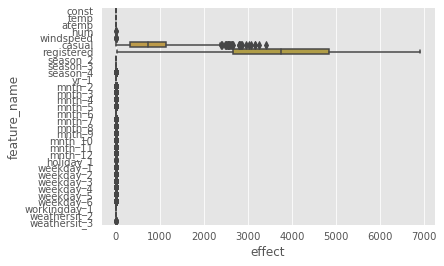

In [123]:
temp_data = []
for j in range(len(features)):
    for i in range(effect_data.shape[0]):
        temp_data.append([features[j], effect_data.iloc[i, j]])

temp_df = pd.DataFrame(columns=['feature_name', 'effect'], data=temp_data)
display(temp_df.head())

sns.boxplot(x='effect', y='feature_name', data=temp_df)

since we can again notice that the box plot of `casual` and `registered` is quite different, we need to visualize them separately.

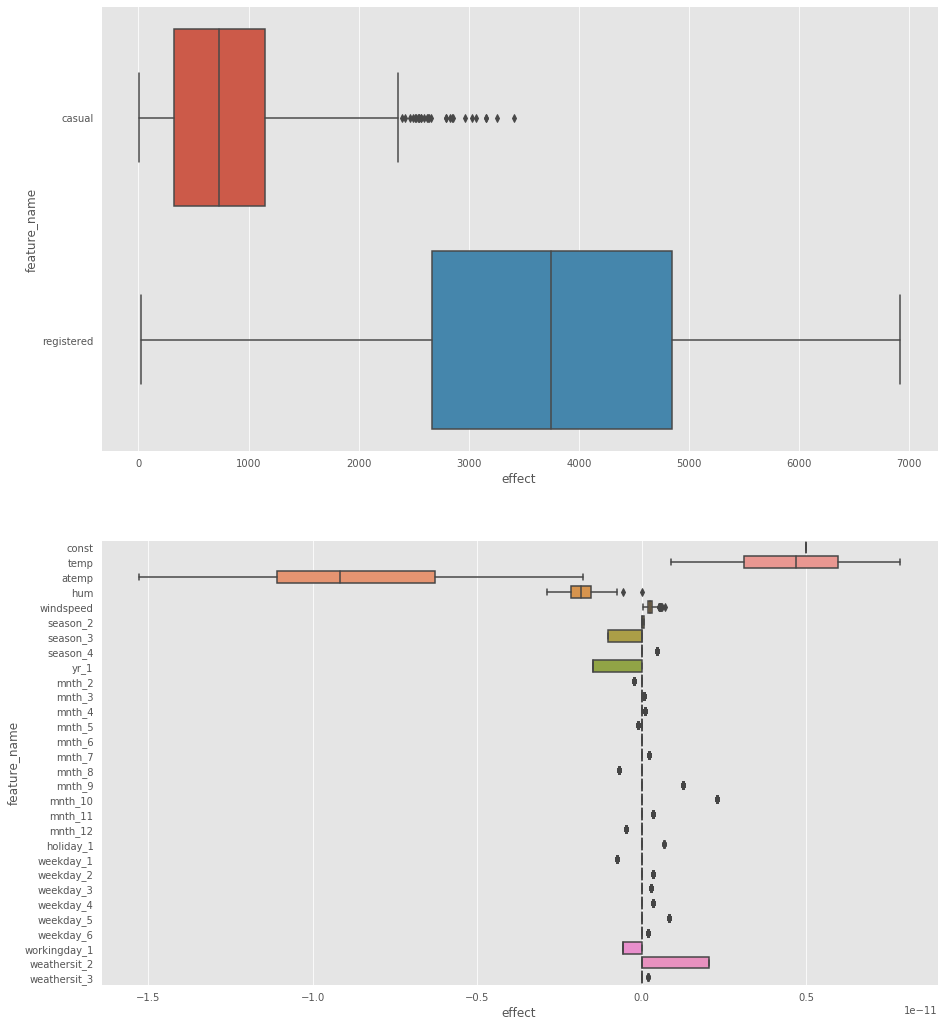

In [124]:
fig, ax = plt.subplots(2, 1, figsize=(15, 18))

sns.boxplot(
    x='effect', 
    y='feature_name', 
    data=temp_df[(temp_df['feature_name'] == 'casual') | (temp_df['feature_name'] == 'registered')], 
    ax=ax[0]
)
sns.boxplot(
    x='effect', 
    y='feature_name', 
    data=temp_df[(temp_df['feature_name'] != 'casual') & (temp_df['feature_name'] != 'registered')], 
    ax=ax[1]
)

so from both, the **weight** and **effect** plots, its concluded that:
1. only `casual` and `registered` features have very high effect on the number of bikes that go out.
2. amongst other features, `atemp` and `temp` are the ones that have the next greatest weights and effects.

In [127]:
print(np.mean(x_train['windspeed']), np.std(x_train['windspeed']))

0.19139910821917808 0.07797275237202676


<font size="6" color="Red">this is happening primarily due to these 2 fields **NOT BEING NORMALIZED**, hence normalize al features and then produce all plots.</font>